# Hit cluster classification

In this notebook we will try to use Keras and XGBoost to distinguish hits according to their ionization cluster geometric properties

In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2023-01-24 12:34:24.640132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Process the variables and select them as signal vs background.  We define 'signal' as when the true drift distance of the threshold-crossing cluster is (somewhat arbitrary value) larger than the true geometric distance of closest approach to the wire, and background as the opposite.  Note that we select the sample to be only active hits that were generated by the true particle.

In [2]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
filelist = os.environ['KKTrainDriftFiles']
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        trkana = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
        trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]
    udoca = ak.concatenate(trkana['detsh.udoca']).to_numpy()
    udoca = np.absolute(udoca)
    cdrift = ak.concatenate(trkana['detsh.cdrift']).to_numpy()
    rdrift = ak.concatenate(trkana['detsh.rdrift']).to_numpy()
    tottdrift = ak.concatenate(trkana['detsh.tottdrift']).to_numpy()
    edep = ak.concatenate(trkana['detsh.edep']).to_numpy()
    sint = ak.concatenate(trkana['detsh.wdot']).to_numpy()
    sint = np.sqrt(1.0-sint*sint)
    plen = 6.25-rdrift*rdrift
    pmin = np.repeat(0.25,plen.shape[0])
    plen = np.sqrt(np.maximum(plen,pmin))
    edep = edep*sint/plen
    hstate = ak.concatenate(trkana['detsh.state']).to_numpy()
    print("Processed file " + filename + " with %s hits"%udoca.shape[0])
    temp = np.vstack((udoca,cdrift,tottdrift, edep)).T
    
    if input_dataset is np.empty:
        input_dataset = temp
    else:
        input_dataset = np.concatenate((input_dataset, temp))
    mcrel = []
    mccdist = []
    mcdist = []
    for i, this_dt in enumerate(trkana['detsh.udoca']):
        mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])
        mccdist.extend(trkana['detshmc.cdist'][i][:len(this_dt)])
        mcdist.extend(trkana['detshmc.dist'][i][:len(this_dt)])
    mcrel = np.array(mcrel)
    mccdist = np.array(mccdist)
    mcdist = np.array(mcdist)

    sig = (hstate>-2) & (mcrel==0) & (mccdist-mcdist<0.4) & (udoca<10.0)
    bkg = (hstate>-2) & (mcrel==0) & (mccdist-mcdist>0.6) & (udoca<10.0)
    if signal is np.empty:
        signal = sig
        backgnd = bkg
    else:
        signal = np.concatenate((signal,sig))
        backgnd = np.concatenate((backgnd,bkg))    
nhits=len(input_dataset)
nsignal=signal.sum()
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))

Using files in /Users/brownd/data/65661719/files.txt
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000000.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000000.root
 with 578423 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000010.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000010.root
 with 581735 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000020.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000020.root
 with 581740 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000030.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000030.root
 with 577941 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000040.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000040.root
 with

In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for _unbalanced_ datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.  Note that the training samples need to be a whole increment of the batch size.

In [3]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

x_input = np.concatenate((signal_dataset, bkg_dataset))
y_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = x_input.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size=0.5, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

Training on 831168 matched hits


In [4]:
udoca_sig = []
tottdrift_sig = []
cdrift_sig = []
edep_sig = []
    
for i in range(signal_dataset.shape[0]):
    udoca_sig.append(signal_dataset[i][0])
    
for i in range(signal_dataset.shape[0]):
    cdrift_sig.append(signal_dataset[i][1])
    
for i in range(signal_dataset.shape[0]):
    tottdrift_sig.append(signal_dataset[i][2])
    
for i in range(signal_dataset.shape[0]):
    edep_sig.append(signal_dataset[i][3])

In [5]:
udoca_back = []
tottdrift_back = []
cdrift_back = []
edep_back = []
    
for i in range(bkg_dataset.shape[0]):
    udoca_back.append(bkg_dataset[i][0])
    
for i in range(bkg_dataset.shape[0]):
    cdrift_back.append(bkg_dataset[i][1])
    
for i in range(bkg_dataset.shape[0]):
    tottdrift_back.append(bkg_dataset[i][2])

for i in range(bkg_dataset.shape[0]):
    edep_back.append(bkg_dataset[i][3])

<function matplotlib.pyplot.show(close=None, block=None)>

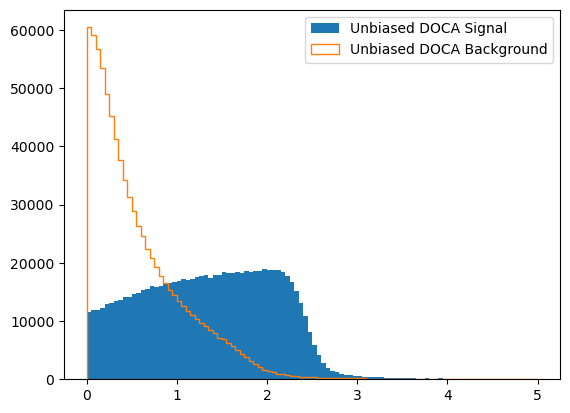

In [6]:
plt.hist(udoca_sig,label="Unbiased DOCA Signal", bins=100,range=(0,5))
plt.hist(udoca_back,label="Unbiased DOCA Background", histtype='step', bins=100,range=(0,5))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

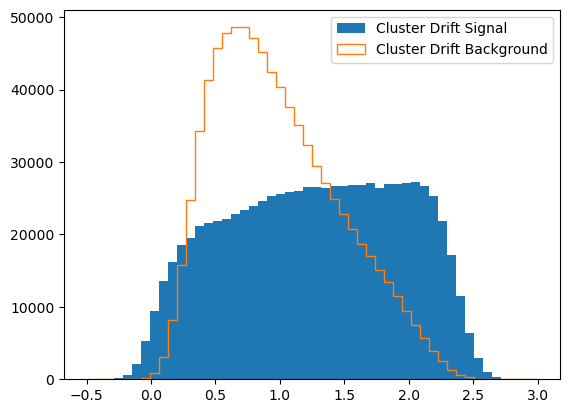

In [7]:
plt.hist(cdrift_sig,label="Cluster Drift Signal", bins=50,range=(-0.5,3.0))
plt.hist(cdrift_back,label="Cluster Drift Background", histtype='step', bins=50, range=(-0.5,3.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

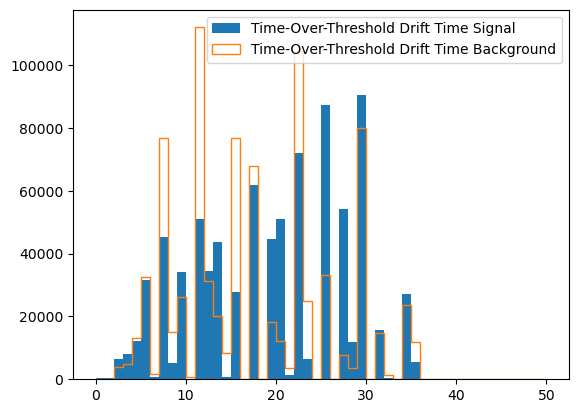

In [8]:
plt.hist(tottdrift_sig,label="Time-Over-Threshold Drift Time Signal", bins=50, range=(0,50))
plt.hist(tottdrift_back,label="Time-Over-Threshold Drift Time Background", histtype='step', bins=50,range=(0,50))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

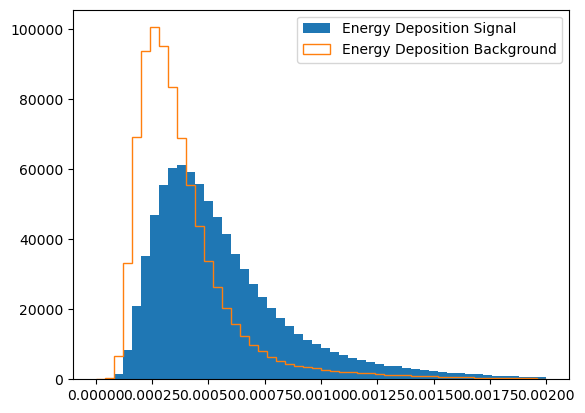

In [9]:
plt.hist(edep_sig,label="Energy Deposition Signal",bins=50,range=(0,0.002))
plt.hist(edep_back,label="Energy Deposition Background", histtype='step', bins=50, range=(0,0.002))
plt.legend()
plt.show

## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained until the validation loss doesn't improve for 10 epochs (`early_stop`).  Instead of starting from scratch we should reload the previous model, that will greatly speed convergence.  TODO

In [10]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input,outputs=output)
model.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history = model.fit(x_train, y_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_valid, y_valid),
                          callbacks=[early_stop]
                         )

2023-01-24 12:45:37.416975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
25974/25974 [==============================] - 35s 1ms/step - loss: 0.4310 - accuracy: 0.8120 - val_loss: 0.4217 - val_accuracy: 0.8217
Epoch 2/200
25974/25974 [==============================] - 34s 1ms/step - loss: 0.4114 - accuracy: 0.8244 - val_loss: 0.4092 - val_accuracy: 0.8256
Epoch 3/200
25974/25974 [==============================] - 34s 1ms/step - loss: 0.4093 - accuracy: 0.8248 - val_loss: 0.4078 - val_accuracy: 0.8260
Epoch 4/200
25974/25974 [==============================] - 33s 1ms/step - loss: 0.4080 - accuracy: 0.8254 - val_loss: 0.4063 - val_accuracy: 0.8267
Epoch 5/200
25974/25974 [==============================] - 30s 1ms/step - loss: 0.4064 - accuracy: 0.8256 - val_loss: 0.4030 - val_accuracy: 0.8270
Epoch 6/200
25974/25974 [==============================] - 30s 1ms/step - loss: 0.4022 - accuracy: 0.8264 - val_loss: 0.4042 - val_accuracy: 0.8262
Epoch 7/200
25974/25974 [==============================] - 32s 1ms/step - loss: 0.4003 - accuracy: 0.8275 - val_

## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT)

## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish the left-right ambiguity sign

In [11]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_train, y_train)

/Users/brownd/mambaforge/envs/KKTrain/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [12]:
prediction = model.predict(x_test).ravel()
fpr, tpr, th = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)

12987/12987 [==============================] - 7s 508us/step


In [13]:
prediction_xgboost = model_xgboost.predict_proba(x_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_test, prediction_xgboost)

When the ANN training is optimized, it should be nearly as good as the BDT.  We use the ANN inference function, as that is faster to compute and is supported by the SOFIE tool applied downstream

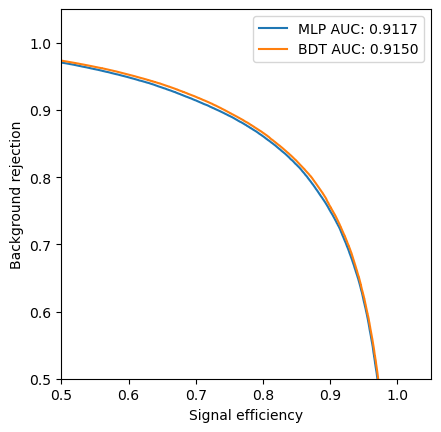

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr,1-fpr,label=f'MLP AUC: {auc:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.5,1.05)
ax.set_ylim(0.5,1.05)
fig.savefig("TrainClusterROC.pdf")

In [15]:
output_model.set_weights(model.get_weights())
output_model.summary()
output_model.save("TrainCluster.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 4)]                  0         
                                                                 
 dense (Dense)               (1, 8)                    40        
                                                                 
 dense_1 (Dense)             (1, 8)                    72        
                                                                 
 dense_2 (Dense)             (1, 8)                    72        
                                                                 
 dense_3 (Dense)             (1, 1)                    9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
